In [119]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [120]:
class PINN(nn.Module):
    def __init__(self, layers):
        super(PINN, self).__init__()
        self.layers = nn.ModuleList()
        for i in range(len(layers) - 1):
            self.layers.append(nn.Linear(layers[i], layers[i+1]))

    def forward(self, x):
        for layer in self.layers[:-1]:
            x = torch.tanh(layer(x))
            # x = torch.sin(layer(x))  # Use sine activation instead of tanh
        return self.layers[-1].forward(x)

    def pde_loss(self, colloc_pts):
        u = self.forward(colloc_pts)
        u_x = torch.autograd.grad(u, colloc_pts, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        u_xx = torch.autograd.grad(u_x, colloc_pts, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
        pde_residual = u_xx + (torch.pi ** 2) * torch.sin(torch.pi * colloc_pts) ** 2
        return torch.mean(pde_residual ** 2)

    def boundary_loss(self, bc_points, bc_values):
        u_bc = self.forward(bc_points)
        return torch.mean((u_bc - bc_values) ** 2)

torch.manual_seed(0)


Training with L-BFGS...
[0] PDE loss: 36.029568, BC loss: 0.000004, Total: 36.029572
[10] PDE loss: 6.077536, BC loss: 0.002541, Total: 6.080077
[20] PDE loss: 0.722838, BC loss: 0.004819, Total: 0.727657
[30] PDE loss: 0.564295, BC loss: 0.005473, Total: 0.569768
[40] PDE loss: 0.354505, BC loss: 0.003737, Total: 0.358243
[50] PDE loss: 0.184259, BC loss: 0.003332, Total: 0.187591
[60] PDE loss: 0.048039, BC loss: 0.004272, Total: 0.052311
[70] PDE loss: 0.007568, BC loss: 0.004149, Total: 0.011717
[80] PDE loss: 0.006625, BC loss: 0.004104, Total: 0.010728
[90] PDE loss: 0.002938, BC loss: 0.004462, Total: 0.007400
[100] PDE loss: 0.002282, BC loss: 0.004674, Total: 0.006955
[110] PDE loss: 0.011004, BC loss: 0.003025, Total: 0.014028
[120] PDE loss: 0.003302, BC loss: 0.001402, Total: 0.004705
[130] PDE loss: 0.002503, BC loss: 0.001251, Total: 0.003754
[140] PDE loss: 0.002528, BC loss: 0.001179, Total: 0.003707
[150] PDE loss: 0.004739, BC loss: 0.000787, Total: 0.005526
[160] PDE

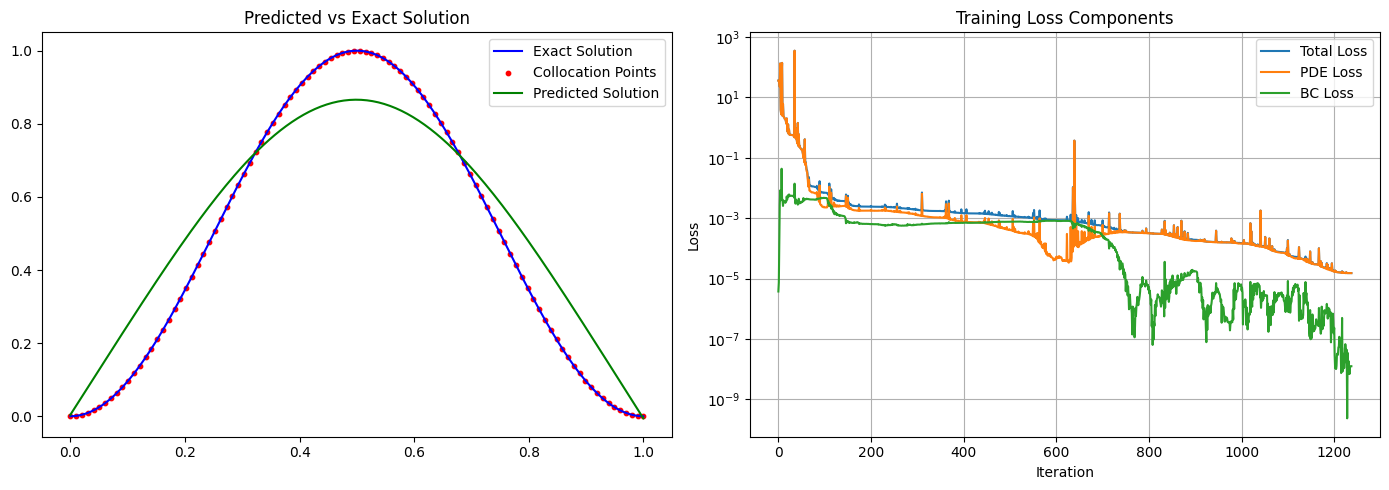

In [ ]:
# Increase both width and depth
model = PINN([1, 50, 50, 50, 50, 1])

# Training data
colloc_pts = torch.linspace(0, 1, 100, requires_grad=True, dtype=torch.float32).view(-1, 1)
bc_pts = torch.tensor([[0.0], [1.0]], dtype=torch.float32)
bc_values = torch.tensor([[0.0], [0.0]], dtype=torch.float32)

optimizer = optim.LBFGS(model.parameters(), lr=2, max_iter=1000, max_eval=50000, history_size=50, line_search_fn='strong_wolfe')

closure_calls = {'count': 0}

losses = []
all_losses = []

def closure():
    optimizer.zero_grad()
    pde_loss_val = model.pde_loss(colloc_pts)
    bc_loss_val = model.boundary_loss(bc_pts, bc_values)
    lamda_bc = 0.0005
    total_loss = pde_loss_val + lamda_bc * bc_loss_val
    losses.append(total_loss)
    total_loss.backward()
    if torch.isnan(total_loss):
        raise ValueError("Loss became NaN during training")
    if closure_calls['count'] % 10 == 0:
      print(f"[{closure_calls['count']}] PDE loss: {pde_loss_val.item():.6f}, BC loss: {lamda_bc * bc_loss_val.item():.6f}, Total: {total_loss.item():.6f}")
    
    all_losses.append({
        'total': total_loss.item(),
        'pde': pde_loss_val.item(),
        'bc': bc_loss_val.item() * lamda_bc
    })
    closure_calls['count'] += 1
    return total_loss

# Train
print("Training with L-BFGS...")
optimizer.step(closure)

# Evaluate
model.eval()
dense_pts = np.linspace(0, 1, 200)
u_exact = np.sin(np.pi * dense_pts) ** 2

with torch.no_grad():
    dense_pts_tensor = torch.tensor(dense_pts, dtype=torch.float32).view(-1, 1)
    u_pred = model(dense_pts_tensor).detach().numpy()

fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Exact vs Predicted
axs[0].plot(dense_pts, u_exact, label='Exact Solution', color='blue')
axs[0].scatter(colloc_pts.detach().numpy(), np.sin(np.pi * colloc_pts.detach().numpy()) ** 2,
               color='red', label='Collocation Points', s=10)
axs[0].plot(dense_pts, u_pred, label='Predicted Solution', color='green')
axs[0].legend()
axs[0].set_title("Predicted vs Exact Solution")

# Plot 2: Loss Curves
axs[1].semilogy([l['total'] for l in all_losses], label='Total Loss')
axs[1].semilogy([l['pde'] for l in all_losses], label='PDE Loss')
axs[1].semilogy([l['bc'] for l in all_losses], label='BC Loss')
axs[1].set_title("Training Loss Components")
axs[1].set_xlabel("Iteration")
axs[1].set_ylabel("Loss")
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()
